In [1]:
using Random
using LinearAlgebra
using Distributions
using BenchmarkTools

using PhDSE

┌ Info: Precompiling PhDSE [7ecd2ffa-f4c5-4dad-8846-8d8820c20168]
└ @ Base loading.jl:1662


In [2]:
include("_setup.jl");

In [3]:
Ns = [10, 100, 500, 1000, 5000, 10000, 20000];

In [4]:
Ds = [10, 100, 500, 1000, 5000, 10000, 20000];

In [5]:
function bench(; D, d, N, benchmark_samples=1)
    Φ, Q, u, H, R, v, y, μ₀, Σ₀ = kalman_setup(D=D, d=d)
    Rinv = inv(R)
    
    # Allocate memory
    fcache = EnKFCache(
        D,
        d,
        ensemble_size = N,
        process_noise_dist = MvNormal(zeros(D), Q),
        observation_noise_dist = MvNormal(zeros(d), R),
    )
    init_ensemble = rand(MvNormal(μ₀, Σ₀), N)
    copy!(fcache.forecast_ensemble, init_ensemble)
    
    bres = @benchmark enkf_correct!($fcache, $H, $Rinv, $y, $v)
    return bres
end

bench (generic function with 1 method)

In [6]:
in_ms(t::BenchmarkTools.Trial) = minimum(t).time / 1e6

in_ms (generic function with 1 method)

In [7]:
benchmark_results_per_D = BenchmarkTools.Trial[]
benchmark_results_per_N = BenchmarkTools.Trial[];

In [8]:
for D in Ds
    bres = bench(D=D, d=D, N=5)
    push!(benchmark_results_per_D, bres)
    println("D = $D ---> $(in_ms(bres)) ms")
end

D = 10 ---> 0.0045132857142857145 ms
D = 100 ---> 0.035183 ms
D = 500 ---> 0.549155 ms
D = 1000 ---> 3.579355 ms
D = 5000 ---> 123.352831 ms
D = 10000 ---> 486.52123 ms
D = 20000 ---> 1927.847308 ms


In [9]:
for N in Ns
    bres = bench(D=5, d=5, N=N)
    push!(benchmark_results_per_N, bres)
    println("N = $N ---> $(in_ms(bres)) ms")
end

N = 10 ---> 0.004661428571428572 ms
N = 100 ---> 0.052132 ms
N = 500 ---> 0.749999 ms
N = 1000 ---> 2.999729 ms
N = 5000 ---> 183.061849 ms
N = 10000 ---> 1190.422983 ms
N = 20000 ---> 8675.264521 ms


In [10]:
using Plots

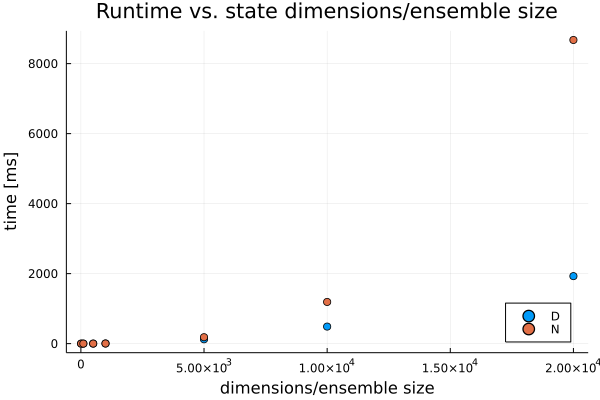

In [13]:
scatter(
    Ds, 
    map(in_ms, benchmark_results_per_D), 
    title="Runtime vs. state dimensions/ensemble size", 
    xlabel="dimensions/ensemble size", 
    ylabel="time [ms]", 
    label="D",
    legend=:bottomright,
)
scatter!(
    Ns, 
    map(in_ms, benchmark_results_per_N), 
    label="N"
)